In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [2]:
FIG_DIR = "../reports/figures"
DATA_PATH = "../data/processed/emails_merged.csv"
df = pd.read_csv(DATA_PATH, encoding='utf-8-sig')

# 1. BASIC OVERVIEW

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sender         49529 non-null  object 
 1   date           49377 non-null  object 
 2   subject        82139 non-null  object 
 3   body           82485 non-null  object 
 4   urls           49860 non-null  float64
 5   label          82486 non-null  int64  
 6   combined_text  82486 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.4+ MB


In [4]:
# Explore missing values
missing_values = df.isnull().sum()
print("Missing values in each column:") 
print(missing_values)

Missing values in each column:
sender           32957
date             33109
subject            347
body                 1
urls             32626
label                0
combined_text        0
dtype: int64


In [5]:
# Explore duplicate entries
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate entries: {duplicate_count}")

Number of duplicate entries: 0


# 2. LABEL DISTRIBUTION

Label distribution:
0: 39595 (48.00%)
1: 42891 (52.00%)


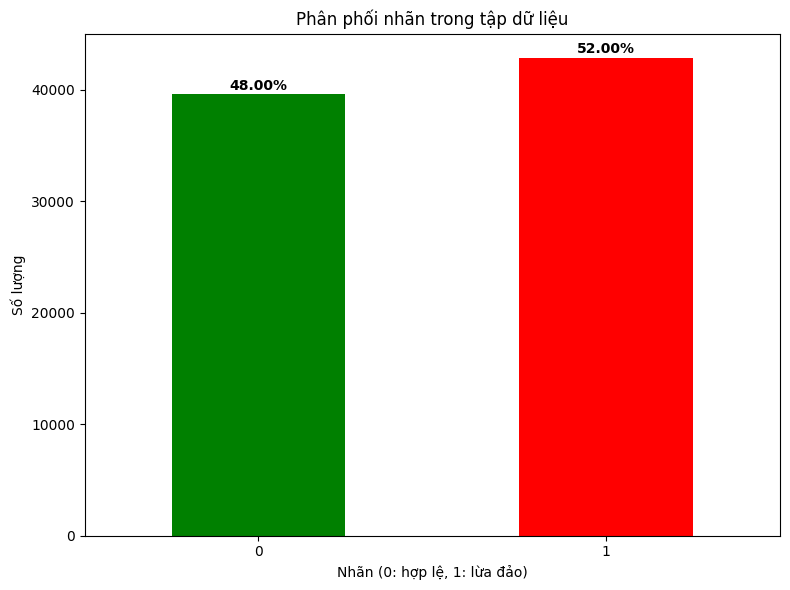

In [6]:
label_counts = df['label'].value_counts().sort_index()
label_percents = df['label'].value_counts(normalize=True).sort_index() * 100

print("Label distribution:")
for label in label_counts.index:
    print(f"{label}: {label_counts[label]} ({label_percents[label]:.2f}%)")

plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar', color=['green', 'red'])

plt.xticks(rotation=0)
plt.title('Phân phối nhãn trong tập dữ liệu')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Số lượng')

# Ghi % lên đầu cột (đúng trục)
for i, label in enumerate(label_counts.index):
    count = label_counts[label]
    percent = label_percents[label]
    ax.text(
        i,
        count + label_counts.max() * 0.01,
        f"{percent:.2f}%",
        ha='center',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/label_distribution.png", dpi=300)
plt.show()

In [7]:
#Class imbalance metrics
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"Tỷ lệ mất cân bằng của 2 nhãn: {imbalance_ratio:.2f}")

Tỷ lệ mất cân bằng của 2 nhãn: 1.08


Phân phối nhãn trong tập dữ liệu tương đối cân bằng. Tỷ lệ mất cân bằng 1.08 cho thấy mức chênh lệch giữa hai lớp là không đáng kể, phù hợp để huấn luyện mô hình phân loại mà không cần áp dụng các kỹ thuật xử lý mất cân bằng dữ liệu phức tạp.

# 3. TEXT LENGTH ANALYSIS

In [8]:
df['text_length'] = df['combined_text'].astype(str).apply(len)

print("Thống kê độ dài văn bản theo label:")
print(df.groupby('label')['text_length'].describe(
    percentiles=[.25, .5, .75, .90, .99]
    ).round(2))

Thống kê độ dài văn bản theo label:
         count     mean       std   min    25%     50%     75%     90%  \
label                                                                    
0      39595.0  2199.04   5386.49  16.0  566.0  1116.0  2177.0  4324.6   
1      42891.0  1423.61  22905.74   3.0  245.0   502.0  1500.5  3900.0   

            99%        max  
label                       
0      18561.96   299272.0  
1       8394.20  4599694.0  


C:\Users\Bcmyg\AppData\Local\Temp\ipykernel_30004\351771933.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df, palette=['green', 'red'])


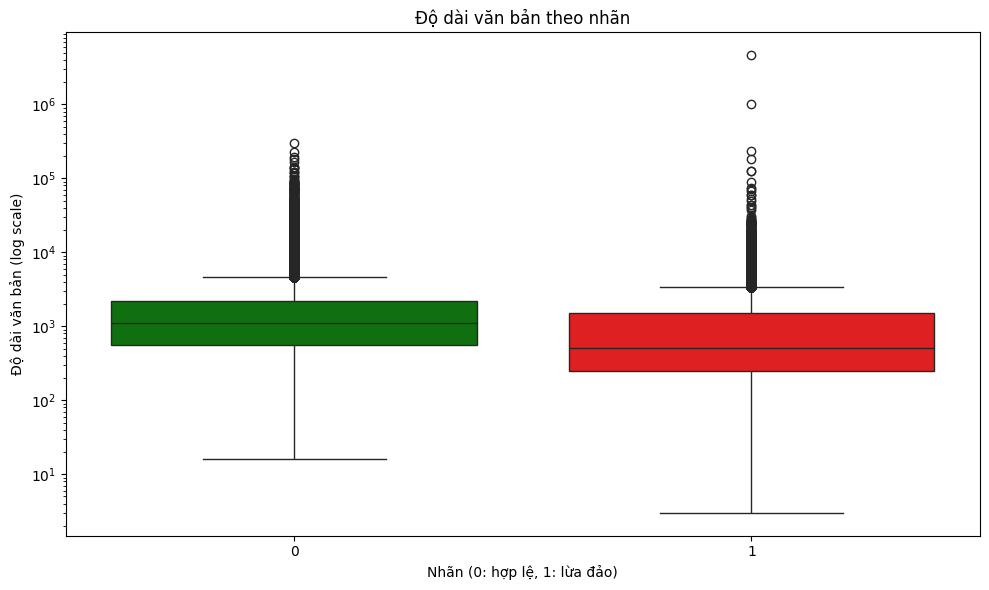

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df, palette=['green', 'red'])
plt.yscale('log')
plt.title('Độ dài văn bản theo nhãn')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Độ dài văn bản (log scale)')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/text_length_by_label.png", dpi=300)
plt.show()

Phishing emails ngắn hơn đáng kể (mean: 1,423 vs 2,199), nhưng có outlier cực lớn (max: 4.6M ký tự). Cần xử lý outlier trước khi training.

In [10]:
threshold = 20000
df_trimmed = df[df['text_length'] <= threshold]

removed_ratio = 1 - len(df_trimmed) / len(df)
print(f"Tỷ lệ mẫu vượt threshold {threshold}: {removed_ratio:.2%}")

Tỷ lệ mẫu vượt threshold 20000: 0.51%


C:\Users\Bcmyg\AppData\Local\Temp\ipykernel_30004\636756899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df_trimmed, palette=['green', 'red'])


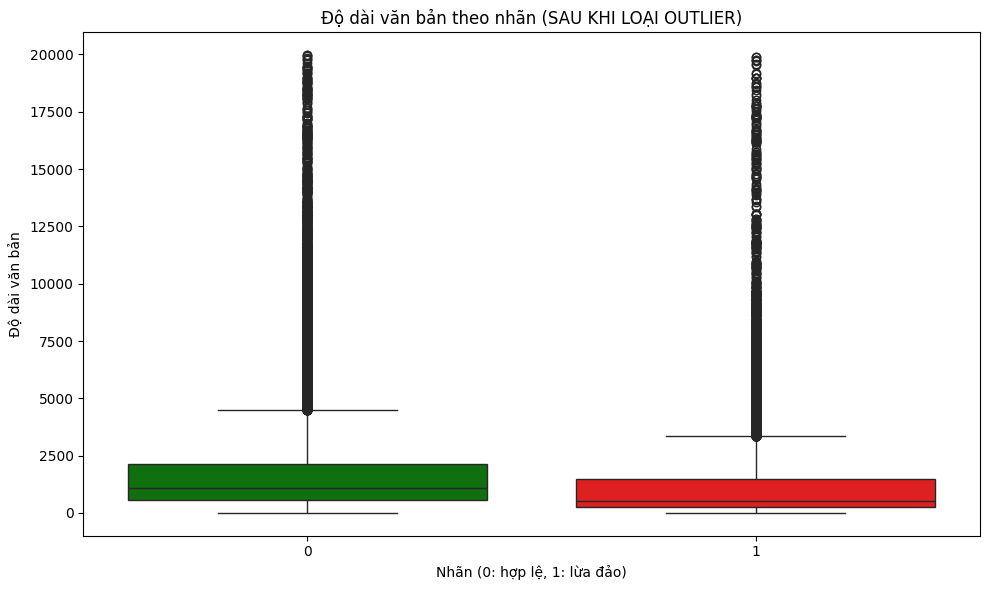

Thống kê SAU KHI LOẠI OUTLIER:
         count     mean      std   min    25%     50%     75%      max
label                                                                 
0      39231.0  1818.13  2226.42  16.0  561.0  1105.0  2132.0  19963.0
1      42835.0  1240.70  1755.73   3.0  245.0   500.0  1487.5  19885.0


In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df_trimmed, palette=['green', 'red'])
plt.title('Độ dài văn bản theo nhãn (SAU KHI LOẠI OUTLIER)')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Độ dài văn bản')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/text_length_by_label_cleaned.png", dpi=300)
plt.show()

# Thống kê lại
print("Thống kê SAU KHI LOẠI OUTLIER:")
print(df_trimmed.groupby('label')['text_length'].describe().round(2))

Sau khi loại bỏ các ngoại lệ có độ dài văn bản vượt quá 20.000 ký tự
(dựa trên phân vị 99%), phân phối độ dài văn bản trở nên ổn định hơn,
với độ lệch và phương sai giảm đáng kể trong cả hai lớp.
Sự khác biệt về độ dài giữa email hợp lệ và email lừa đảo
vẫn được duy trì, cho thấy việc xử lý outlier không làm mất
thông tin phân biệt của dữ liệu.

# 4. URL ANALYSIS

In [12]:
df['num_urls']= df['combined_text'].astype(str).apply(
    lambda x: len(re.findall(r'http[s]?://\S+', x)))
print("Thống kê số lượng URL theo nhãn:")
print(df.groupby('label')['num_urls'].describe().round(2))

Thống kê số lượng URL theo nhãn:
         count  mean    std  min  25%  50%  75%     max
label                                                  
0      39595.0  1.71  17.72  0.0  0.0  0.0  1.0  3131.0
1      42891.0  2.07   6.36  0.0  0.0  0.0  1.0   279.0


In [13]:
df['has_url'] = (df['num_urls'] > 0).astype(int)
print("Tỷ lệ email có URL theo nhãn:")
print(df.groupby('label')['has_url'].value_counts(normalize=True).round(2))

Tỷ lệ email có URL theo nhãn:
label  has_url
0      0          0.62
       1          0.38
1      0          0.60
       1          0.40
Name: proportion, dtype: float64


In [14]:
df['num_ip_urls']= df['combined_text'].astype(str).apply(
    lambda x: len(re.findall(r'http[s]?://\d{1,3}(?:\.\d{1,3}){3}\S*', x)))
print("Thống kê số lượng URL dạng IP theo nhãn:")
print(df.groupby('label')['num_ip_urls'].describe().round(2))

Thống kê số lượng URL dạng IP theo nhãn:
         count  mean   std  min  25%  50%  75%   max
label                                               
0      39595.0  0.00  0.08  0.0  0.0  0.0  0.0  15.0
1      42891.0  0.01  0.19  0.0  0.0  0.0  0.0  18.0


In [15]:
df['has_ip_url'] = df['combined_text'].astype(str).apply(
    lambda x: int(bool(re.search(r'http[s]?://(\d{1,3}\.){3}\d{1,3}(:\d+)?(/\S*)?', x))))
print("Thống kê URL chứa địa chỉ IP theo nhãn:")    
print(df.groupby('label')['has_ip_url'].value_counts(normalize=True).round(3))

Thống kê URL chứa địa chỉ IP theo nhãn:
label  has_ip_url
0      0             0.999
       1             0.001
1      0             0.997
       1             0.003
Name: proportion, dtype: float64


Email phishing có xu hướng chứa nhiều URL hơn email hợp lệ
(mean: 2.07 so với 1.71) và tỷ lệ email có URL cũng cao hơn (40% vs 38%).

URL dạng địa chỉ IP xuất hiện rất hiếm trong dữ liệu,
nhưng tỷ lệ này cao hơn ở phishing emails, cho thấy đây là tín hiệu hiếm
nhưng có khả năng phân biệt mạnh.

C:\Users\Bcmyg\AppData\Local\Temp\ipykernel_30004\240133044.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label',y='num_urls',data=df,palette=['green', 'red'],)


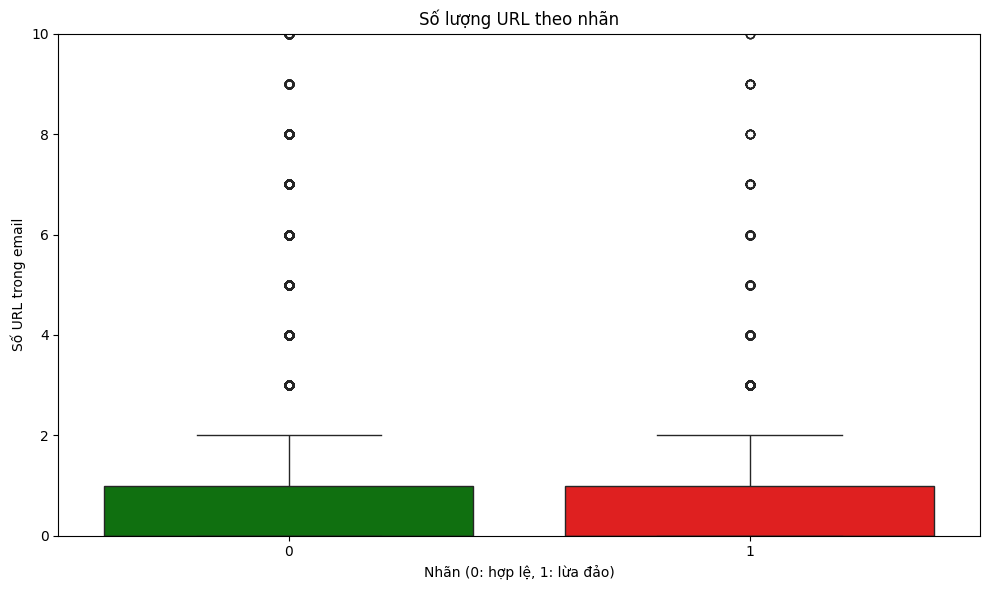

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label',y='num_urls',data=df,palette=['green', 'red'],)
plt.ylim(0, 10)
plt.title('Số lượng URL theo nhãn')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Số URL trong email')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/num_urls_boxplot.png", dpi=300)
plt.show()

C:\Users\Bcmyg\AppData\Local\Temp\ipykernel_30004\4021333135.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


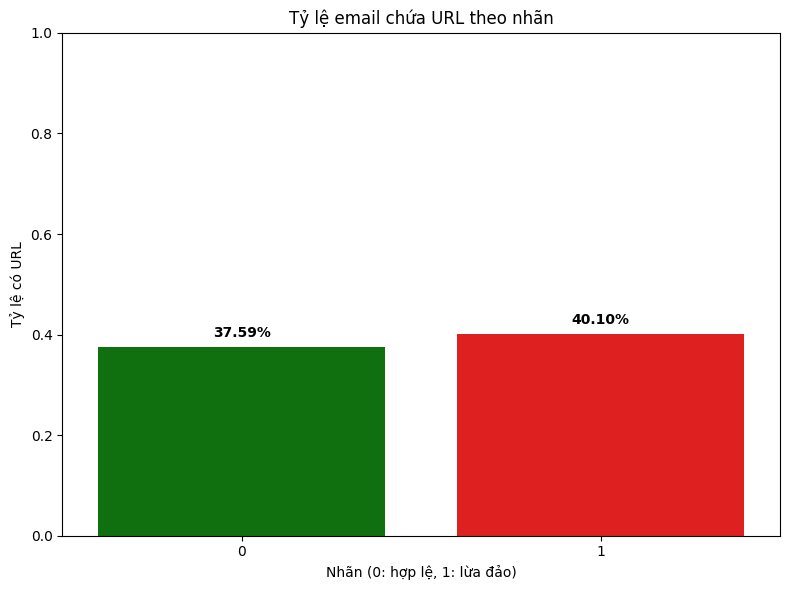

In [17]:
url_ratio = (
    df.groupby('label')['has_url']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='label',
    y='has_url',
    data=url_ratio,
    palette=['green', 'red']
)
plt.title('Tỷ lệ email chứa URL theo nhãn')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Tỷ lệ có URL')
plt.ylim(0, 1)

for i, v in enumerate(url_ratio['has_url']):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/has_url_ratio.png", dpi=300)
plt.show()


C:\Users\Bcmyg\AppData\Local\Temp\ipykernel_30004\964069121.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


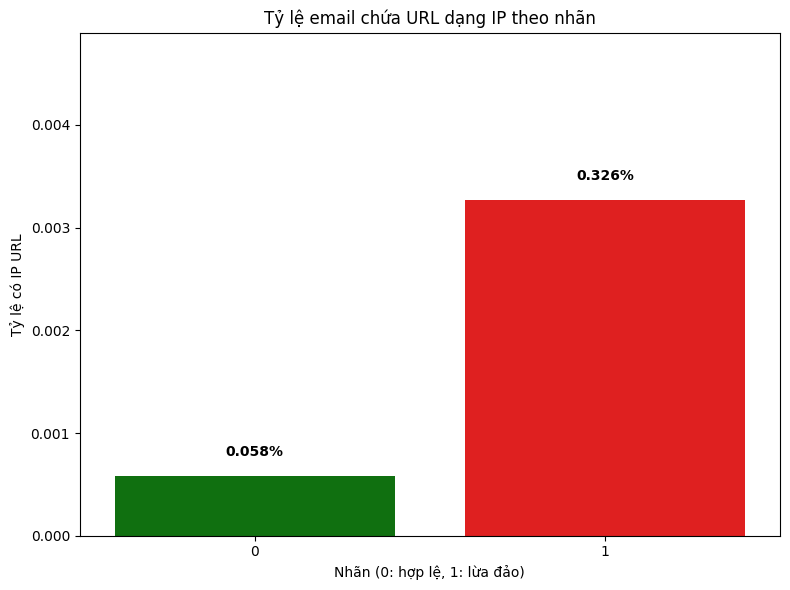

In [18]:
ip_ratio = (
    df.groupby('label')['has_ip_url']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='label',
    y='has_ip_url',
    data=ip_ratio,
    palette=['green', 'red']
)
plt.title('Tỷ lệ email chứa URL dạng IP theo nhãn')
plt.xlabel('Nhãn (0: hợp lệ, 1: lừa đảo)')
plt.ylabel('Tỷ lệ có IP URL')
plt.ylim(0, ip_ratio['has_ip_url'].max() * 1.5)

for i, v in enumerate(ip_ratio['has_ip_url']):
    plt.text(i, v + 0.0002, f"{v:.3%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/ip_url_ratio.png", dpi=300)
plt.show()


Phishing emails có xu hướng chứa nhiều URL hơn email hợp lệ,
đồng thời có tỷ lệ URL dạng địa chỉ IP cao hơn dù xuất hiện rất hiếm.
Điều này cho thấy đặc trưng URL, đặc biệt là IP-based URL,
là tín hiệu hữu ích để bổ trợ cho mô hình phát hiện phishing.